## Load documents with IDs ##

In [3]:
filepath = './data/documents-with-ids.json'

In [6]:
import json
with open(filepath, 'r') as f:
    documents = json.load(f)

In [7]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [8]:
documents[11]

{'text': "No, you can only get a certificate if you finish the course with a “live” cohort. We don't award certificates for the self-paced mode. The reason is you need to peer-review capstone(s) after submitting a project. You can only peer-review projects at the time the course is running.",
 'section': 'General course-related questions',
 'question': 'Certificate - Can I follow the course in a self-paced mode and get a certificate?',
 'course': 'data-engineering-zoomcamp',
 'id': 'cb257ee5'}

In [11]:
import pandas as pd
filepath = './data/ground-truth-data.csv'
df_ground_truth = pd.read_csv(filepath)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [12]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [13]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [14]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

## Index Data ## 

In [15]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/Users/ron/Documents/github/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [17]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

## Retrieval ##

In [18]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [19]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': '(Hrithik Kumar Advani)',
  'section': '2. Machine Learning for Regression',
  'question': 'Useful Resource for

## The RAG Flow ##

In [20]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [22]:
import os
import getpass
#os.environ

In [23]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI API key:\n")

OPENAI API key:
 ········


In [24]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [25]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [26]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [27]:
rag(ground_truth[10])

'Yes, sessions are recorded, so you won’t miss anything if you miss one. You can watch the recordings and ask any questions in advance for office hours, which will be covered during the live stream. Additionally, you can ask questions on Slack.'

In [28]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric ##

In [30]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.7591172)

In [31]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [32]:
len(ground_truth)

1830

In [33]:
ground_truth_dummy = ground_truth[0:75]

In [34]:
ground_truth_dummy[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [35]:
ground_truth_dummy[-1]

{'question': 'Can I submit homework if I join the course after it has started?',
 'course': 'machine-learning-zoomcamp',
 'document': 'ee58a693'}

In [36]:
answers = {}

In [37]:
for i, rec in enumerate(tqdm(ground_truth_dummy)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|          | 0/75 [00:00<?, ?it/s]

In [38]:
results_gpt4o = [None] * len(ground_truth_dummy)

In [43]:
answers.get(0)

{'answer_llm': 'You can sign up for the course by going to the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [44]:
results_gpt4o = [None] * len(ground_truth_dummy)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth_dummy[i])

In [46]:
results_gpt4o[0]

{'answer_llm': 'You can sign up for the course by going to the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [47]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [48]:
df_gpt4o.shape

(75, 5)

In [49]:
df_gpt4o.head(5)

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the course through the lin...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The CONTEXT does not provide information about...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,The provided CONTEXT does not contain specific...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [52]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

## Cosine similarity ##

In [53]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [54]:
record = results_gpt4o[0]

In [56]:
record

{'answer_llm': 'You can sign up for the course by going to the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [57]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [85]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/75 [00:00<?, ?it/s]

In [86]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    75.000000
mean      0.613186
std       0.207226
min      -0.045846
25%       0.469019
50%       0.677235
75%       0.767699
max       0.945692
Name: cosine, dtype: float64

In [61]:
!pip install -U seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/wb/_77j3j256dlc5yrp7_0dxfg40000gn/T/ipykernel_89768/1467479441.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')


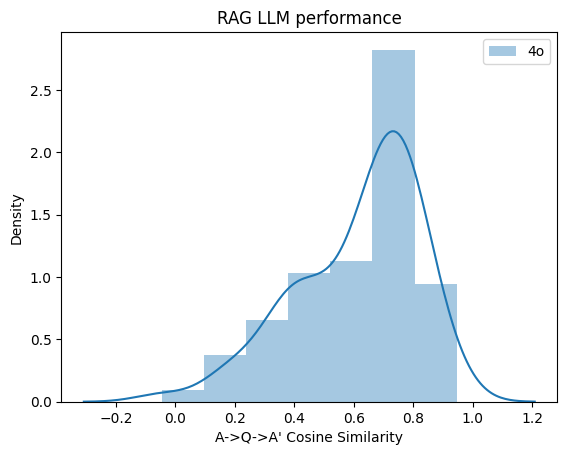

In [64]:
sns.distplot(df_gpt4o['cosine'], label='4o')
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

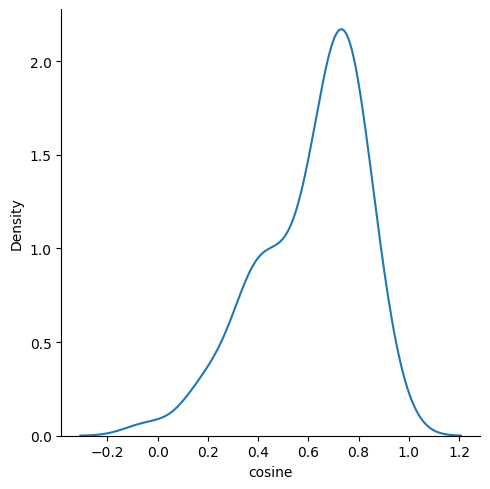

In [65]:
sns.displot(df_gpt4o['cosine'], kind="kde")
plt.show()

## Parallel Execution ##

In [66]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [72]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [73]:
process_record(ground_truth[10])

{'answer_llm': "Yes, everything is recorded so you won't miss anything if you miss a session.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [74]:
results_gpt35 = map_progress(pool, ground_truth_dummy, process_record)

  0%|          | 0/75 [00:00<?, ?it/s]

In [75]:
results_gpt35

[{'answer_llm': "You can sign up for the course by going to the course page at http://mlzoomcamp.com/#syllabus. From there, you can access the course materials and start going through the videos and cohort folders for your cohort's year.",
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'No, I cannot provide a link to sign up. The link for signing up can be found in the course GitHub repository: https://airtable.com/shryxwLd0COOEaqXo.',
  'answer_orig': 'Machine Learning Zoomcamp FA

In [76]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [77]:
!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
"You can sign up for the course by going to the course page at http://mlzoomcamp.com/#syllabus. From there, you can access the course materials and start going through the videos and cohort folders for your cohort's year.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"No, I cannot provide a link to sign up. The link for signing up can be found in the course GitHub repository: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical ques

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## cosine Similarity gpt3.5 turbo ##   

In [81]:
results_gpt35 = df_gpt35.to_dict(orient='records')

In [82]:
len(results_gpt35)

75

In [83]:
results_gpt35[0]

{'answer_llm': "You can sign up for the course by going to the course page at http://mlzoomcamp.com/#syllabus. From there, you can access the course materials and start going through the videos and cohort folders for your cohort's year.",
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [87]:
similarity_35 = []
for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/75 [00:00<?, ?it/s]

In [89]:
len(similarity), len(similarity_35)

(75, 75)

In [90]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    75.000000
mean      0.611080
std       0.227821
min      -0.094383
25%       0.507069
50%       0.668651
75%       0.770926
max       0.953446
Name: cosine, dtype: float64

/var/folders/wb/_77j3j256dlc5yrp7_0dxfg40000gn/T/ipykernel_89768/1722685275.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/var/folders/wb/_77j3j256dlc5yrp7_0dxfg40000gn/T/ipykernel_89768/1722685275.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35

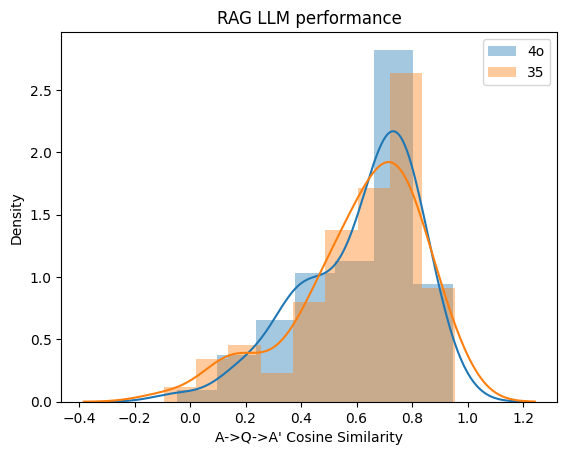

In [91]:
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt35['cosine'], label='35')
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-judge ##

In [93]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [94]:
prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [100]:
samples = df_gpt4o.to_dict(orient='records')

In [104]:
record = samples[0]
record

{'answer_llm': 'You can sign up for the course by going to the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.4178880453109741}

In [105]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work
Generated Question: Where can I sign up for the course?
Generated Answer: You can sign up for the course by going to the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).

Please analyze the 

In [106]:
llm

<function __main__.llm(prompt, model='gpt-4o')>

In [108]:
answer = llm(prompt, model='gpt-4o')
answer

'{\n  "Relevance": "NON_RELEVANT",\n  "Explanation": "The original answer provides information about a FAQ document for a machine learning course, with a focus on capturing frequently asked technical questions and referring to a similar resource in a data engineering course. In contrast, the generated answer addresses where to sign up for the course, which is unrelated to the original answer\'s content about the FAQ document and its intended purpose. Thus, the generated answer is not relevant to the original answer."\n}'

In [110]:
import json
json.loads(answer)

{'Relevance': 'NON_RELEVANT',
 'Explanation': "The original answer provides information about a FAQ document for a machine learning course, with a focus on capturing frequently asked technical questions and referring to a similar resource in a data engineering course. In contrast, the generated answer addresses where to sign up for the course, which is unrelated to the original answer's content about the FAQ document and its intended purpose. Thus, the generated answer is not relevant to the original answer."}

In [111]:
evaluations = []
for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o')
    evaluations.append(evaluation)

  0%|          | 0/75 [00:00<?, ?it/s]

In [112]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [113]:
json_evaluations

[{'Relevance': 'NON_RELEVANT',
  'Explanation': "The original answer focuses on the purpose of a FAQ document for a Machine Learning Zoomcamp, highlighting its utility and providing a link to a relevant document. The generated answer, however, addresses a completely different topic by providing information on how to sign up for the course, thus lacking relevance to the original answer's content and context."},
 {'Relevance': 'PARTLY_RELEVANT',
  'Explanation': 'The generated answer provides the same link as the original answer but misinterprets its purpose. The original answer refers to the link as a part of a FAQ document in the GitHub repository, while the generated answer incorrectly states it is a sign-up link. Therefore, the content is related but does not accurately address the context of the original answer.'},
 {'Relevance': 'RELEVANT',
  'Explanation': "The generated answer accurately identifies that there is an FAQ for the Machine Learning course and provides the correct URL 

In [114]:
df_evaluations = pd.DataFrame(json_evaluations)

In [115]:
df_evaluations.shape

(75, 2)

In [117]:
df_evaluations.head()

,Relevance,Explanation
0,NON_RELEVANT,The original answer focuses on the purpose of ...
1,PARTLY_RELEVANT,The generated answer provides the same link as...
2,RELEVANT,The generated answer accurately identifies tha...
3,NON_RELEVANT,The generated answer does not address the orig...
4,PARTLY_RELEVANT,The generated answer acknowledges the lack of ...


In [119]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           44
PARTLY_RELEVANT    24
NON_RELEVANT        7
Name: count, dtype: int64

In [128]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'].to_dict(orient='records')

[{'Relevance': 'NON_RELEVANT',
  'Explanation': "The original answer focuses on the purpose of a FAQ document for a Machine Learning Zoomcamp, highlighting its utility and providing a link to a relevant document. The generated answer, however, addresses a completely different topic by providing information on how to sign up for the course, thus lacking relevance to the original answer's content and context."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer does not address the original answer's content, which is about a FAQ document for a Machine Learning Zoomcamp and a specific GitHub link related to that document. Instead, the generated answer incorrectly focuses on whether there's a sign-up link in a GitHub repository, which is not mentioned in the original answer."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer addresses a different aspect of a certificate requirement and provides additional details about project completion criteria, 

In [124]:
samples[67]

{'answer_llm': 'Based on the provided context, there is no explicit mention of a requirement to provide the URL to your GitHub repository. However, it is indicated that the GitHub repository should be public, so whoever corrects the homework can access it. If a public link is needed for this purpose, then providing the URL would make sense, but this specific requirement is not directly addressed in the context.',
 'answer_orig': "Here’s how you join a in Slack: https://slack.com/help/articles/205239967-Join-a-channel\nClick “All channels” at the top of your left sidebar. If you don't see this option, click “More” to find it.\nBrowse the list of public channels in your workspace, or use the search bar to search by channel name or description.\nSelect a channel from the list to view it.\nClick Join Channel.\nDo we need to provide the GitHub link to only our code corresponding to the homework questions?\nYes. You are required to provide the URL to your repo in order to receive a grade",
 

In [127]:
evaluations_2 = []
for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  0%|          | 0/75 [00:00<?, ?it/s]

In [129]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [130]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [134]:
df_evaluations_2[df_evaluations_2.Relevance == 'PARTLY_RELEVANT']

,Relevance,Explanation
3,PARTLY_RELEVANT,The generated answer addresses the question by...
4,PARTLY_RELEVANT,The generated answer acknowledges the lack of ...
21,PARTLY_RELEVANT,The generated answer mentions linear algebra a...
26,PARTLY_RELEVANT,The generated answer directly addresses the po...
33,PARTLY_RELEVANT,The generated answer provides some information...
43,PARTLY_RELEVANT,The generated answer does not provide a specif...
67,PARTLY_RELEVANT,The generated answer touches on the need for a...
74,PARTLY_RELEVANT,The generated answer addresses the question ab...


In [133]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           67
PARTLY_RELEVANT     8
Name: count, dtype: int64

## save the data ##

In [135]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)

In [136]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)